<a href="https://www.kaggle.com/code/thasankakandage/analysis-of-cnns-with-mnist?scriptVersionId=204409654" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Data Preparation**

Using Keras to import the MNIST dataset, the training set should contain 60000 images of dimension 28x28 with their labels

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
print("Number of training images:", X_train.shape[0])
print("Dimension of the images:", X_train.shape[1:])
print("Number of training labels (should be 10 classes, digits 0-9):", len(np.unique(y_train)))
print("\nNumber of testing images:", X_test.shape[0])
print("Number of testing labels (should be 10 classes, digits 0-9):", len(np.unique(y_test)))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of training images: 60000
Dimension of the images: (28, 28)
Number of training labels (should be 10 classes, digits 0-9): 10

Number of testing images: 10000
Number of testing labels (should be 10 classes, digits 0-9): 10


# **EDA**

### **Distribution of Classes**

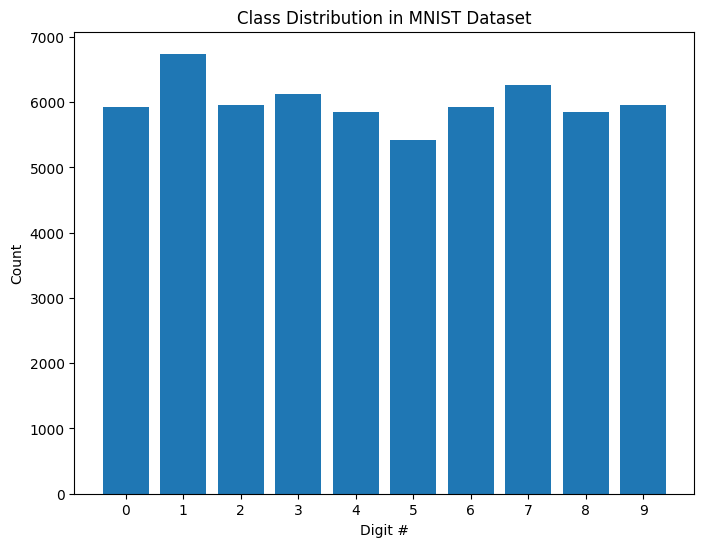

In [2]:

classes, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(classes, counts)
plt.title('Class Distribution in MNIST Dataset')
plt.xlabel('Digit #')
plt.ylabel('Count')
plt.xticks(classes)
plt.show()


Pretty even distribution of classes!



### **Visualization of Some Random Samples**

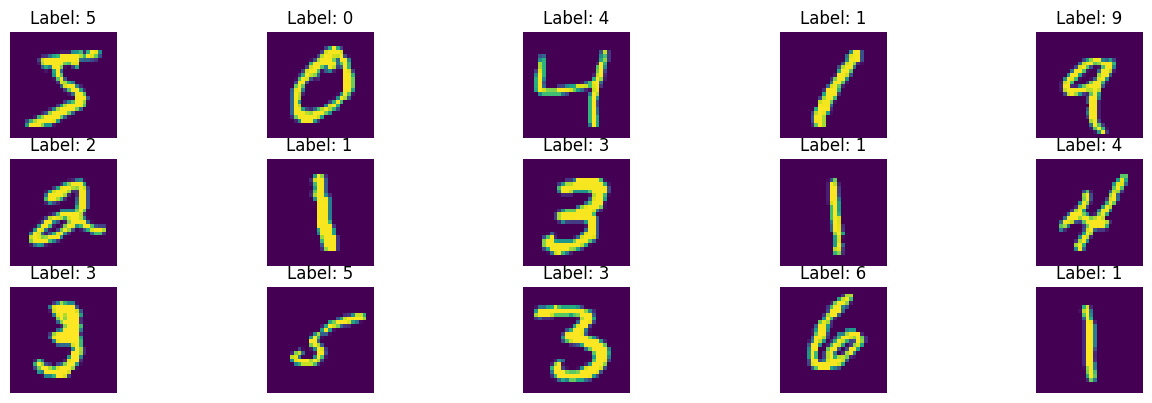

In [3]:
plt.figure(figsize=(16,8))

for i in range(15):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i])
  plt.title(f'Label: {y_train[i]}')
  plt.axis('off')

## **Variance of Images and their Pixels**
Since these are handwritten images, the variance between different digits will vary greatly. It is extremely rare that two individuals have the same writing style.

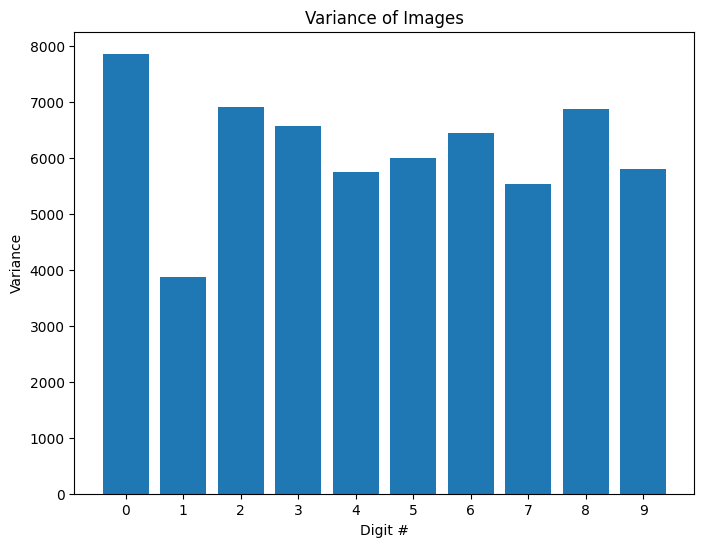

In [4]:
variances = [np.var(X_train[y_train == i]) for i in range(10)]

plt.figure(figsize=(8,6))
plt.bar(range(10), variances)
plt.title('Variance of Images')
plt.xlabel('Digit #')
plt.ylabel('Variance')
plt.xticks(range(10))
plt.show()

From this plot, we can see that the digit 1 has very low variance compared to the other numbers. This implies that the digit 1 is drawn fairly similarily across different handwriting styles. Lets investigate this to see if its true by plotting some random 1 digits in the dataset.

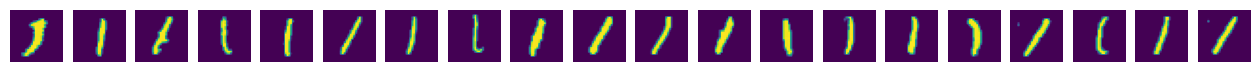

In [5]:
plt.figure(figsize=(16,8))

# first lets just select the random indices where the label is 1
random_1_indices = np.random.choice(np.where(y_train == 1)[0], size=20, replace=False)

# then just select these indices in the training image set
sampled_1s = X_train[random_1_indices]

for i in range(20):

  plt.subplot(1, 20, i+1)
  plt.imshow(sampled_1s[i])
  plt.axis('off')

plt.show()


They all look fairly the same, so the low variance from the plot above is valid.

### **Plotting the Average Image of Each Digit**
This analysis is important to plot, from this we can see the average image of what approximately a digit should look. It helps to see the variation of each image by seeing what parts of the image vary.





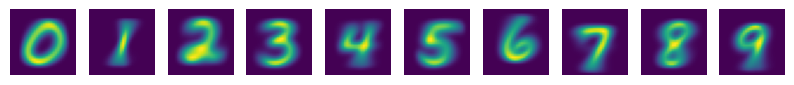

In [6]:
mean_image_digit = []
for i in range(10):
    mean_image_digit.append(np.mean(X_train[y_train == i], axis=0))

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(mean_image_digit[i])
    plt.axis('off')
plt.show()


 Take a look at the digit 1, some individuals draw the digit as a straight line, while others add additional parts to the digit, which explains how the top and bottom spread out a small amount. Similarily, the digit 2 also shows some variance. In the bottom of the 2 digit you can see there is a blurry line, as some individiuals write their twos with a loop at the bottom and others just a straight line. Comparing this to digits 3 and 5, these look more uniform as they are drawn consistently across different handwriting styles, there really is only one way to draw a 3 or a 5 but not necessarily a 1 or a 2.



# What is a Convolutional Neural Network (CNN)
The CNN that will be developed in the notebook is largely based on the common LeNet architecture, a CNN based on 7 layers. These layers consist of 3 convolutional layers, 2 pooling layers, and 2 fully connected (dense) layers in a specific order. More information can be learned about the LeNet architecture in
this [Kaggle notebook](https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide).

First, lets discuss the layers that will make the up the neural network (NN) in an abstract way so we get a better understanding of the inner mechanisms.






## Layers

### **Convolutional Layer**
This is the main layer used in CNNs that is very good at processing grid-like data, which is the exact case for images that are defined by their height and width in pixels. Esentially, there is a matrix called the filter or kernel that passes over the image matrix and performs convolution operations. When the filters are sliding through the image matrix, they return feature maps that represent how certain features like edges, textures, curves, etc are present in different parts of the image. Different filters in the layer are designed to detect different types of patterns, so eventually the feature maps are stacked together to form the output of the convolutional layer which captures multiple levels of detail from the input.



### **Pooling Layers**

Pooling layers usually comes right after convolutional layers. This layer simply reduces the size of the feature maps for numerous reasons but some are:

- **reduce complexity**. Smaller images → faster time to compute and lower amount of weights
- extract only the most important features in smaller areas


The pooling layers act as a form of regularization, a method to prevent overfitting, as they reduce model complexity by simplifying feature maps

In this notebook we will use **max pooling**, which simply gets the max value in the size of filter as it passes through the image matrix.

For example, lets assume this is our image matrix

1 3 2 4

5 6 2 1

3 2 6 5

7 8 3 1

And we apply a 2x2 max pooling filters, we would return

6 4

8 5


### **Fully-Connected (FC) Layers**
FC or dense layers works by connecting every neuron from the previous layer (the flattened vector usually from the output of a pooling layer) to every neuron in the FC layer and produces an output by applying a set of weights and biases. Before going into these layers, the pooled feature map outputs are flattened from 3D to a 1D vector.

For example, if you have 32 feature maps, each of size 7x7, flattening would result in a 1D vector of length
32
×
7
×
7
=
1568
32×7×7=1568.

After it passes to the FC layer, it then goes to the output layer to produce the final prediction for a classification or regression task.


### **Activation Functions**
Activation functions are used in NNs to introduce non-linearity into the model. Without them, a NN would simply behave like a linear regression model, no matter how many layers it has, limiting its ability to learn complex patterns. Non-linearity simply means that the model can go beyond just detecting straight lines or basic shapes and can now recognize intricate patterns and features in the data.

In this model we are going to use two specific activation functions, Rectified Linear Unit (ReLU) and a Softmax function.

ReLU has a simple equation, f(x) = max(0, x) and is usually applied after convolutional or FC layers where it helps to keep important information by removing negative values.

Softmax is fairly more complex but very important in classification tasks, which is what we are doing in this notebook. Esentially this function is used in the FC layers so that their outputs form a probability distribution.
Each output neuron represents a class (so 10 output neurons in our case), and the softmax function makes sure that the sum of the probabilities for all classes equals 1, making it easy to interpret the models confidence in each class.

# **One-Hot Encoding**
This simple encoding technique is used to convert categorical data to a format that is easier to understand for the ML model. It simply creates a long binary where one category is **hot** and given a value of one, and the rest are **cold** and given a value of zero.

For example, lets assume we are working with the image of digit 6 and has the label 6.

One hot encoding would turn this 6 into a binary format like this:

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0] === This is the new label for the image 6

If we do not use these and instead use the labels as is (they are already numerically categorized after all), the ML model may interpret it as a **ordinal relationship** and learn undesirable hiearchies between categories. This simply means that the higher number is seemed as a greater category, so 9 > 8 > 7 ... > 0 which is not true in our case.

In [7]:
from keras.utils import to_categorical # to_categorical is the onehot encoder from keras


y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(y_train[:5])


[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# **K-Fold Cross-Validation**
To discuss what K-Fold Cross Validation is, first we need to describe what testing validation does during training. Validation is simply how good a model works on a validation dataset, which is data seperate from the training set. The key purpose of validation is to ensure that the model is not only performing well on the training data but can also generalize to unseen data.

Normally you just partition another % of the whole dataset to create the validation dataset but, with K-Fold Cross-Validation we can create validation data in another way. The dataset is randomly split into K subsets or folds, in our case we are going to have 5 folds (K=5), and we have 60000 datapoints for training, so each fold should contain 12000 datapoints. Then, the model is trained and validated K (5) times and each time the model is tested and this goes until the remaining K-1 folds are used as the training set. The process continues until each fold has been used as the validation set once.

We are also adding stratification to the method to make sure each fold has the same of class labels, which leads to more reliable performance.

In [8]:
from sklearn.model_selection import StratifiedKFold
# setting up the fold cross validation with k = 5
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


# **Building the CNN**

The loss being used is **categorical crossentropy**, which is used when there is a classification problem with more than 2 classes (otherwise use binary crossentropy). It must have a one-hot encoded label format and a softmax activation function to ensure the sum of probabilities add to 1.


Lets think of the layers that we are going to build, this will be based on the [LeNet architecture stated above](#scrollTo=ve3C9Nq1tw_K&line=3&uniqifier=1).

1. **Input Layer** - accepting the 28x28 features here, so this will have 28x28=784 neurons
2. **Convolutional Layer** - first convolution layer in our system, here we will specify how many filters we want, this will create however many filter maps, and the size of these filters that wil pass through the image.
We will also include a activation function, specifically ReLU, so it can learn non-linear patterns
3. **Pooling Layer** - first pooling layer in our system, here we are going to use max pooling with a specificed pool size to reduce the feature maps from the convolutional layer
4. **Convolutional Layer** - second convolutional layer, again, similar to the first one we will specificy how many filters we want and their size
5. **Pooling Layer** - second pooling layer, pooling layer again, similar to the previous ones.
6. **FC (Dense) Layer** - Connecting the flattened vector from the pooling layer to a dense layer with 128 neurons
  - **Why 128?** Common number of neurons, same as 64, 256, or 512. The number of neurons is also something to test around with, but 128 is a pretty good balance between being general enough to do different kinds of task but also not to overcomplicate the model. Also, like many other numbers used as paramters it is a power of 2 which lets it aligns a bit better with hardware.
7. **Output Layer** - After passing through the FC layer, it goes here to the output layer and depending on which of the 10 neurons has the highest probability, will give that neurons class.

**Why 2 sets of Convolutional and Pooling layers?** Many reasons as to why more layers are better, but a main reason is that the first layers learn simple features, but as you grow the amount of layers, they will learn more complex patterns and functions.
Having multiple sets of these layers is good for allowing the model to learn a hiearchy of features [(like this image)](#scrollTo=gTXPLuwzX7Md&line=1&uniqifier=1) and only focus on the most important points of an image.





# Testing Out Different Parameters
Below we will these the following different parameters using K-Fold Cross Validation

Number of Filters = [16, 32]

Learning Rate = [0.001, 0.01]


In [9]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam

# unique class labels from the one-hot encoded array for stratified kfolding
unique_labels = np.unique(np.argmax(y_train, axis=1))

number_of_filters = [16, 32]
learning_rates = [0.001, 0.01]

best_val_accuracy = 0
best_params = {}

# getting all combinations of filters and lr's, 4 in total
for filters in number_of_filters:
    for learning_rate in learning_rates:
        print(f"###### Training with {filter} filters or kernels (will create {filter} feature maps per convolutional layer) and a learning rate of {learning_rate} ######")


        val_accuracies = []

        for i, (train_index, val_index) in enumerate(stratified_kfold.split(X_train, np.argmax(y_train, axis=1))):
            print(f"Training on Fold #{i+1}")


            # splitting to get the validation data
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model = Sequential() # a sequential model to be able to stack the layers


            # input layer with shape (28, 28, 1) for the images of this size
            model.add(Input(shape=(28, 28, 1)))

            # filters, with size 3x3. Image input size will be 28x28
            model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu')) # due to the 3x3 filter, the feature map size will be 26x26
            model.add(MaxPooling2D(pool_size=(2, 2))) # pooling each 2x2 area of the feature map, this will half the size of the feature map

            # 28x28 image -> 26x26 map due to the filter -> 13x13 size due to max pooling of 2x2
            # Input will be 26x26x(X amount of filter feature maps)
            model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu')) # 13x13 -> 3x3 filter -> 11x11
            model.add(MaxPooling2D(pool_size=(2, 2))) # 11x11 -> 2x2 max pooling -> 5x5


            model.add(Flatten()) # flattening the layers so we get a 1D vector suitable for the FC layers
            model.add(Dense(128, activation='relu')) # 128 neurons, too much increases model complexity, too little can't fit/learn well

            model.add(Dense(10, activation='softmax')) # 10 neurons, representing the 10 possible outputs for each class (digits 0-9)

            # compiling  model with specific learning rate
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

            # training, tests on validation after every epoch
            # verbose means the details shown in training, 0 no text?, 1 is a simple line and some metric
            history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=10, batch_size=128, verbose=1)



            # evaluating model on val set
            loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            print(f'Fold {i + 1}: Validation Accuracy: {val_accuracy:.3f}')
            val_accuracies.append(val_accuracy)

        # getting simple mean of val accuracy for this specific param combination
        mean_val_accuracy = np.mean(val_accuracies)
        print(f'Mean Validation Accuracy for {filters} filters and learning rate={learning_rate}: {mean_val_accuracy:.3f}')

        # updating if its better
        if mean_val_accuracy > best_val_accuracy:
            best_val_accuracy = mean_val_accuracy
            best_params = {'filters': filters, 'learning_rate': learning_rate}





###### Training with <class 'filter'> filters or kernels (will create <class 'filter'> feature maps per convolutional layer) and a learning rate of 0.001 ######
Training on Fold #1
Epoch 1/10


I0000 00:00:1730340648.803135      66 service.cc:145] XLA service 0x7dbfbc002d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730340648.803192      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 74/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4079 - loss: 19.7627

I0000 00:00:1730340651.017048      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7130 - loss: 6.5270 - val_accuracy: 0.9481 - val_loss: 0.2128
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9533 - loss: 0.1716 - val_accuracy: 0.9613 - val_loss: 0.1469
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.1016 - val_accuracy: 0.9709 - val_loss: 0.1045
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9783 - loss: 0.0679 - val_accuracy: 0.9708 - val_loss: 0.1075
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9822 - loss: 0.0551 - val_accuracy: 0.9732 - val_loss: 0.0984
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9853 - loss: 0.0463 - val_accuracy: 0.9772 - val_loss: 0.0946
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9887 - loss: 0.0366 - val_accuracy: 0.9778 - val_loss: 0.0894
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9917 - loss: 0.0261 - val_accuracy: 0.9767 - val_

# **Using Final Parameters to Fully Train the CNN**

In [10]:
# best parameters on entire training set
print("Best Parameters:", best_params)
final_model = Sequential()
final_model.add(Input(shape=(28, 28, 1)))
final_model.add(Conv2D(best_params['filters'], kernel_size=(3, 3), activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Conv2D(best_params['filters'], kernel_size=(3, 3), activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Flatten())
final_model.add(Dense(128, activation='relu'))
final_model.add(Dense(10, activation='softmax'))


final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


final_history = final_model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1)

# using on test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy for the Final CNN Model: {test_accuracy:.3f}")

Best Parameters: {'filters': 32, 'learning_rate': 0.001}
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8007 - loss: 3.4023
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9745 - loss: 0.0838
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9822 - loss: 0.0558
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9875 - loss: 0.0378
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9909 - loss: 0.0289
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9916 - loss: 0.0254
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9935 - loss: 0.0197
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9939 - loss: 0.0185
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9931 - loss: 0.0212
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9932 - loss: 0.0218
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9816 - loss: 0.0821

Test A

# **Comparing CNNs to Current Day Image Classifiers**
In this section, we will compare CNNs to modern day image classifiers and I will specifically look at the transformer architecture which is the architecture behind the popular Large Language Models (LLMs) we have today. Although the model has been mostly used for Natural Language Processing (NLP) tasks due to their great ability to work with sequential data because of their self-attention mechanism, they also have been used for image classifcation and those models are called Vision Transformers (ViT).  

CNNs work by having convolutional layers to detect patterns and features by having filters of certain sizes pass through the image. This way, the model processes small regions of the image one at a time and effectively detects hiearchial features as shown from this image from [IBMs article about CNNs](https://www.ibm.com/topics/convolutional-neural-networks):

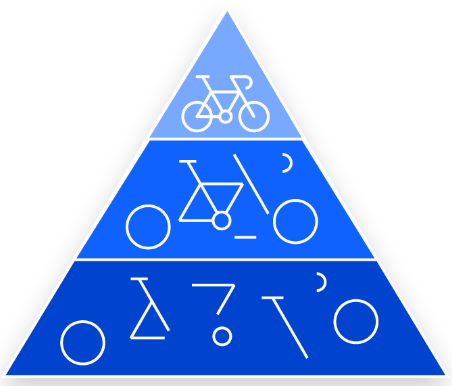


ViTs work by splitting the image into smaller images where each of these smaller images is a token (similar to how they tokenize words in a string), where the self-attention mechanism allows the model to capture relationships between patches which means they learn patterns from the entire image.



[Performance Analysis of a Hybrid Convolutional Vision Transformer (CViT) for Handwritten Digit Recognition](https://www.sciencedirect.com/science/article/pii/S2215016124000098)

- This paper discusses the hybrid combination of a CNN and a ViT, a CViT, on the EMNIST (Extended MNIST) and the largest historical handwritten digit dataset (DIDA).

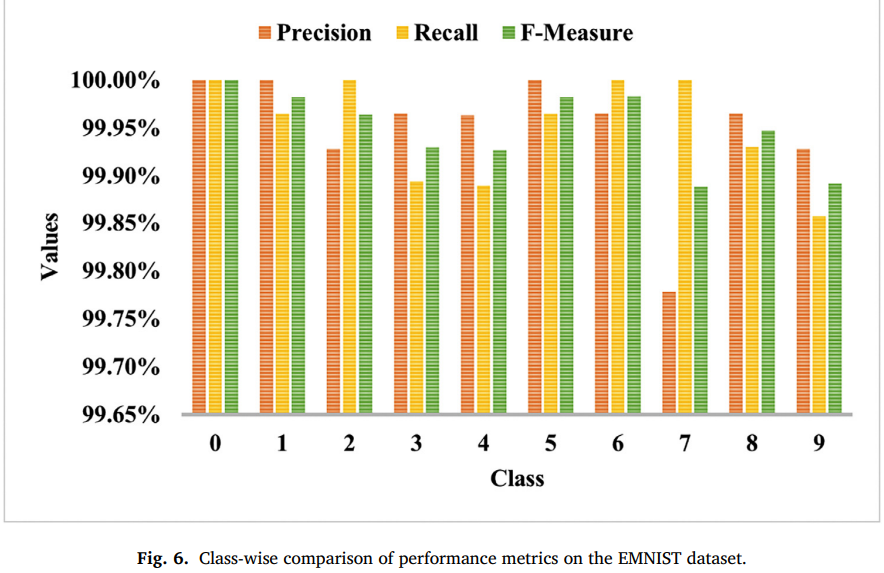

- Even though the CNN model made in this notebook was incredibly accurate, these SotA models are even better.


[1] V. Agrawal, J. Jagtap, S. Patil, and K. Kotecha, ‘Performance analysis of hybrid deep learning framework using a vision transformer and convolutional neural network for handwritten digit recognition’, MethodsX, vol. 12, p. 102554, 2024